# YouTube trending videos

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, precision_score, silhouette_score

from helpers.categories import get_categories_dict
from helpers.files import load_csv

## Etap 4 - Wykorzystanie uczenia pół-nadzorowanego


### Wyczytanie danych

In [128]:
gb_data, us_data = load_csv("clustering_data")

videos = pd.concat([gb_data, us_data])
categories_ids = videos["new_category_id"].dropna().unique().tolist()

### Wczytanie nazw kategorii

In [129]:
categories_dict = get_categories_dict()
categories = [categories_dict[cat] for cat in categories_ids]

## Usunięcie danych tekstowych

In [130]:
videos = videos[videos["new_category_id"].notna()]
y_hat = videos["new_category_id"]  # oczekiwane kategorie z api
y_hat_nans = videos["category_id"]  # oczekiwane kategorie z nanami (z oryginalnego zbioru)
videos_no_nan_categories = videos[videos["category_id"].notna()]
selected_columns = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day",
    "gray_mean_score", "color_mean_score", "gray_hist_score",
    "red_hist_score", "green_hist_score", "blue_hist_score", "edges_score", "entropy_score",
]

for cat in categories_ids:
    selected_columns.append(f"freq_channel_titles_{categories_dict[cat]}")
    selected_columns.append(f"freq_titles_{categories_dict[cat]}")
    selected_columns.append(f"freq_tags_{categories_dict[cat]}")
    selected_columns.append(f"freq_descriptions_{categories_dict[cat]}")

videos = videos[selected_columns]
videos = videos.fillna(videos.mean())
x_not_nan = videos[y_hat_nans.notna()]
y_not_nan = y_hat_nans[y_hat_nans.notna()]

videos_no_nan_categories

,views,likes,dislikes,comment_count,description_len,title_len,channel_title_len,publish_time_day_of_week,publish_time_hour_of_day,gray_mean_score,...,freq_tags_Autos & Vehicles,freq_descriptions_Autos & Vehicles,freq_channel_titles_Travel & Events,freq_titles_Travel & Events,freq_tags_Travel & Events,freq_descriptions_Travel & Events,freq_channel_titles_Nonprofits & Activism,freq_titles_Nonprofits & Activism,freq_tags_Nonprofits & Activism,freq_descriptions_Nonprofits & Activism
0,28725,253,3,12,31.0,31,12,0,17,NaN,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00
4,1770509,163869,2704,7269,751.0,44,11,2,22,1027255.0,...,0.0,0.20,0.0,0.00,0.0,0.15,0.0,0.0,0.0,0.05
5,4651793,251125,1013,12150,331.0,33,6,1,12,642414.0,...,0.0,0.00,0.0,0.00,0.0,0.05,0.0,0.0,0.0,0.00
8,131985,5051,122,504,3405.0,67,9,6,18,750510.0,...,0.0,0.25,0.0,0.05,0.0,0.30,0.0,0.0,0.0,0.10
9,3592011,52578,2414,4919,527.0,40,18,3,8,1072894.0,...,0.0,0.10,0.0,0.05,0.0,0.05,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6322,3321250,66486,2417,4602,389.0,90,9,2,22,1274921.0,...,0.0,0.15,0.0,0.00,0.0,0.15,0.0,0.0,0.0,0.00
6333,261520,19333,124,735,1807.0,34,15,3,16,1411212.0,...,0.0,0.35,0.0,0.00,0.0,0.20,0.0,0.0,0.0,0.20
6339,656819,11856,433,1630,202.0,32,12,5,15,NaN,...,0.0,0.05,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.05
6341,52513,1278,56,432,494.0,63,18,2,20,1093469.0,...,0.0,0.30,0.0,0.00,0.0,0.15,0.0,0.0,0.0,0.05


### Uzupełnienie wartości pustych wartościami średnimi


In [131]:
# videos = videos.fillna(videos.mean())

### K-means

Dobre acc (przypisuje wszyskim jedną klasę ale słaba reszta metryk)
można zastosować bo znamy liczbę klas, do których będziemy przypisywać.

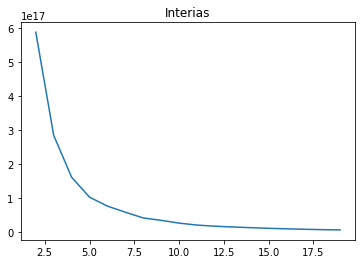

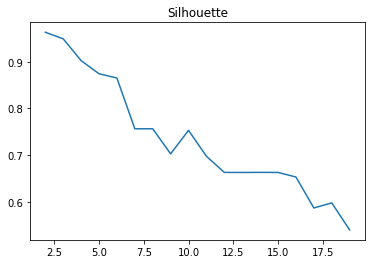

[9 9 0 ... 9 9 5]
y_hat_nans  y
1.0         9     92
2.0         9     11
10.0        9    232
15.0        9     47
17.0        9    135
19.0        9     14
20.0        9     68
22.0        9    156
23.0        9    116
24.0        9    400
25.0        9    126
26.0        9    183
27.0        9     71
28.0        9     74
29.0        9      4
43.0        9      2
Name: c, dtype: int64
{1.0: 9, 2.0: 9, 10.0: 9, 15.0: 9, 17.0: 9, 19.0: 9, 20.0: 9, 22.0: 9, 23.0: 9, 24.0: 9, 25.0: 9, 26.0: 9, 27.0: 9, 28.0: 9, 29.0: 9, 43.0: 9}
Accuracy: 0.7345163136805953
F1: 0.0564627197324709
Precision: 0.06666666666666667
(8735, 20)


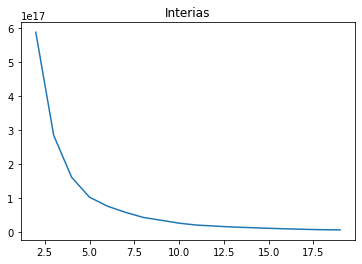

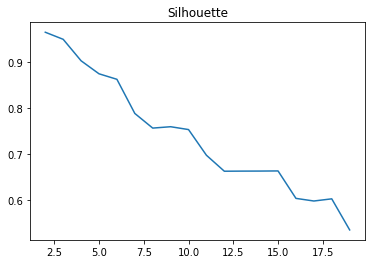

[ 1  1 11 ...  1  1  7]
y_hat_nans  y
1.0         1     92
2.0         1     11
10.0        1    232
15.0        1     47
17.0        1    135
19.0        1     14
20.0        1     68
22.0        1    156
23.0        1    116
24.0        1    400
25.0        1    126
26.0        1    183
27.0        1     71
28.0        1     74
29.0        1      4
43.0        1      2
Name: c, dtype: int64
{1.0: 1, 2.0: 1, 10.0: 1, 15.0: 1, 17.0: 1, 19.0: 1, 20.0: 1, 22.0: 1, 23.0: 1, 24.0: 1, 25.0: 1, 26.0: 1, 27.0: 1, 28.0: 1, 29.0: 1, 43.0: 1}
Accuracy: 0.7345163136805953
F1: 0.0564627197324709
Precision: 0.06666666666666667


In [140]:
select = SelectKBest(chi2, k=20)
select.fit(x_not_nan, y_not_nan)
x = select.transform(videos)
print(x.shape)

k_list = np.arange(2, 20)
inertias = np.zeros_like(k_list, dtype=np.float)
silhouettes = np.zeros_like(k_list, dtype=np.float)
for i, k in enumerate(k_list):
    model = KMeans(k)
    # model.fit(x)
    labels = model.fit_predict(x)
    inertias[i] = model.inertia_
    silhouettes[i] = silhouette_score(x, labels)

plt.plot(k_list, inertias)
plt.title("Interias")
plt.show()
plt.plot(k_list, silhouettes)
plt.title("Silhouette")
plt.show()

model = KMeans(len(categories))
model.fit(x)
y = model.predict(x)
print(y)

def get_mapping_dict(y_hat_nans, y_pred) -> dict:
    mapping_dict = {}
    y_data = pd.DataFrame()
    y_data["y_hat_nans"] = y_hat_nans
    y_data["y"] = y_pred
    y_data["c"] = 1
    y_data = y_data.groupby(["y_hat_nans", "y"])["c"].sum()  #.max(level=[0])#.sort_values().groupby(level=0)
    out = y_data.loc[y_data.groupby(level=0).idxmax()]
    print(out)
    for row in out.index:
        mapping_dict[row[0]] = row[1]
    return mapping_dict


mapping_dict = get_mapping_dict(y_hat_nans, y)
print(mapping_dict)
y_hat_mapped = y_hat.apply(lambda x: mapping_dict[x])
print(f"Accuracy: {accuracy_score(y_hat_mapped, y)}")
print(f"F1: {f1_score(y_hat_mapped, y, average='macro')}")
print(f"Precision: {precision_score(y_hat_mapped, y, average='macro')}")